<a href="https://colab.research.google.com/github/yumpy/fastai-course-v3/blob/master/notes/dl1/teddy-bear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [1]:
!pip install -q torch==1.0.0 torchvision 

     |████████████████████████████████| 591.8MB 30kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.0 which is incompatible.


In [0]:
from fastai.vision import *

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
classes = ['black', 'teddys', 'grizzly']

for folder in classes:
  path = Path('data/bears')
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

### Download URLs from github

In [4]:
!for i in black grizzly teddys; do curl https://raw.githubusercontent.com/yumpy/fastai-course-v3/master/data/bears/urls_$i.csv > data/bears/urls_$i.csv ; done

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72980  100 72980    0     0   316k      0 --:--:-- --:--:-- --:--:--  316k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70566  100 70566    0     0   348k      0 --:--:-- --:--:-- --:--:--  349k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63040  100 63040    0     0   315k      0 --:--:-- --:--:-- --:--:--  315k


In [5]:
path.ls()

[PosixPath('data/bears/teddys'),
 PosixPath('data/bears/urls_grizzly.csv'),
 PosixPath('data/bears/grizzly'),
 PosixPath('data/bears/black'),
 PosixPath('data/bears/urls_black.csv'),
 PosixPath('data/bears/urls_teddys.csv')]

## Download images

Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

You will need to run this line once for every category.

In [0]:
for classname in classes:
  path = Path('data/bears')
  file = 'urls_' + classname + '.csv'
  download_images(path/file, path/classname, max_pics=200)

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [10]:
data.classes

['black', 'grizzly', 'teddys']

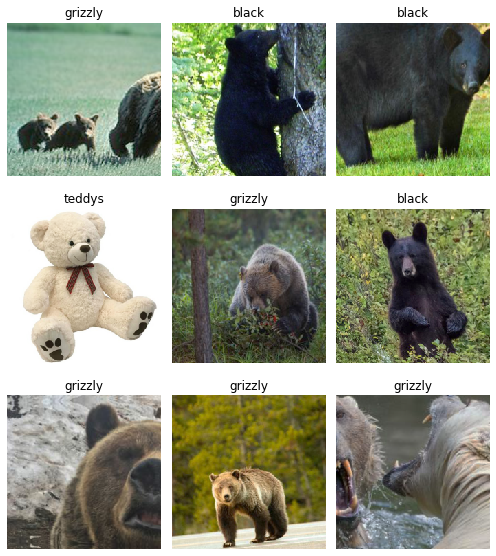

In [11]:
data.show_batch(rows=3, figsize=(7,8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 424, 106)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.128041,0.439578,0.103774,00:12
1,0.671712,0.148842,0.066038,00:09
2,0.467209,0.133103,0.037736,00:10
3,0.353516,0.161711,0.056604,00:10
4,0.291495,0.182802,0.047170,00:10
5,0.244875,0.179171,0.066038,00:09
6,0.211733,0.176055,0.056604,00:09
7,0.181519,0.173323,0.056604,00:10


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


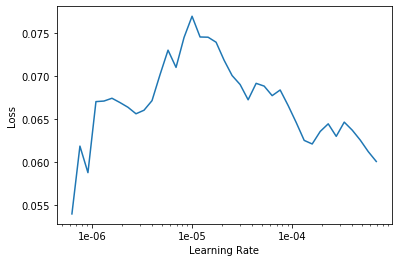

In [19]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(8, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.069767,0.172049,0.056604,00:10
1,0.090623,0.197595,0.056604,00:10
2,0.073171,0.178406,0.047170,00:10
3,0.069871,0.199352,0.047170,00:10
4,0.060543,0.169935,0.047170,00:10
5,0.052351,0.155610,0.056604,00:10
6,0.048089,0.159527,0.066038,00:10
7,0.043313,0.160386,0.066038,00:10


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

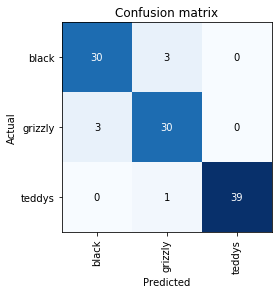

In [24]:
interp.plot_confusion_matrix()

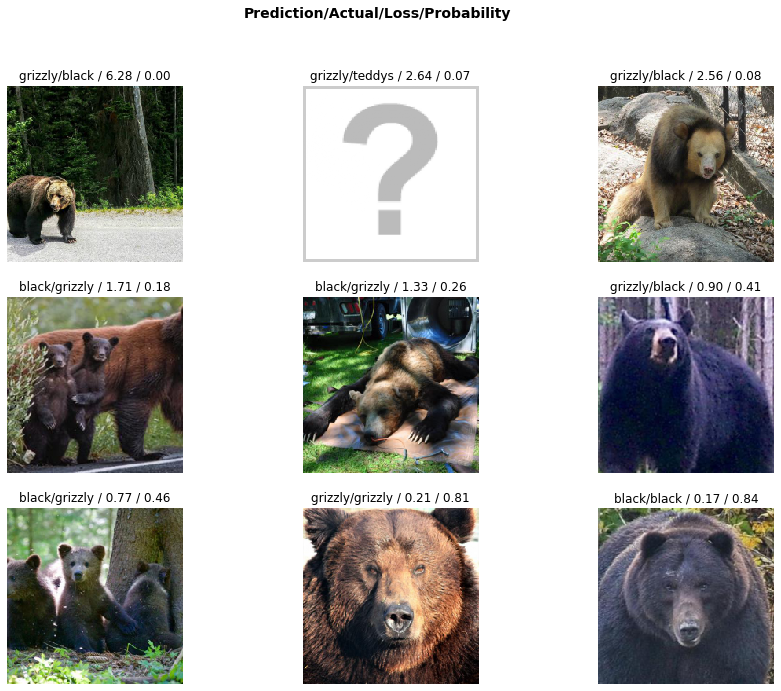

In [39]:
interp.plot_top_losses(9, figsize=(15,11))

In [40]:
interp.most_confused(min_val=2)

[('black', 'grizzly', 3), ('grizzly', 'black', 3)]

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

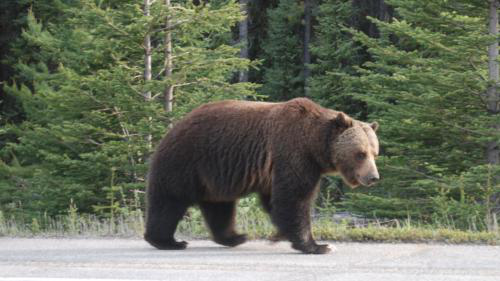

In [64]:
img = open_image(path/'grizzly'/'00000020.jpg')
img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(path)

In [66]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

(Category grizzly, tensor([2.7957e-04, 9.9971e-01, 5.8633e-06]))

In [0]:
!wget https://www.cebugift.com/images/products/large_1926_new-teddy-bear-24.jpg -o log

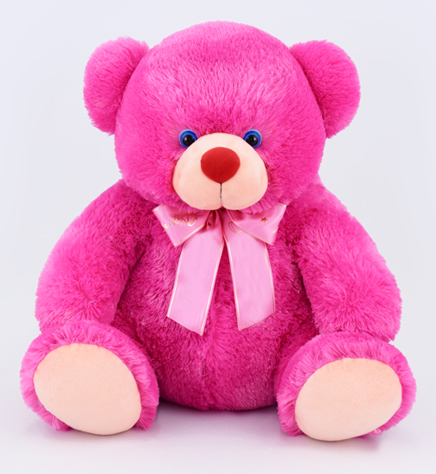

In [62]:
img_teddy = open_image(Path()/'large_1926_new-teddy-bear-24.jpg')
img_teddy

In [63]:
pred_class,pred_idx,outputs = learn.predict(img_teddy)
pred_class

(Category teddys, tensor(2), tensor([6.7561e-08, 1.3931e-07, 1.0000e+00]))

In [0]:
!wget http://img2.chinadaily.com.cn/images/201905/20/5ce1e456a3104842e4ae5bae.jpeg -o log

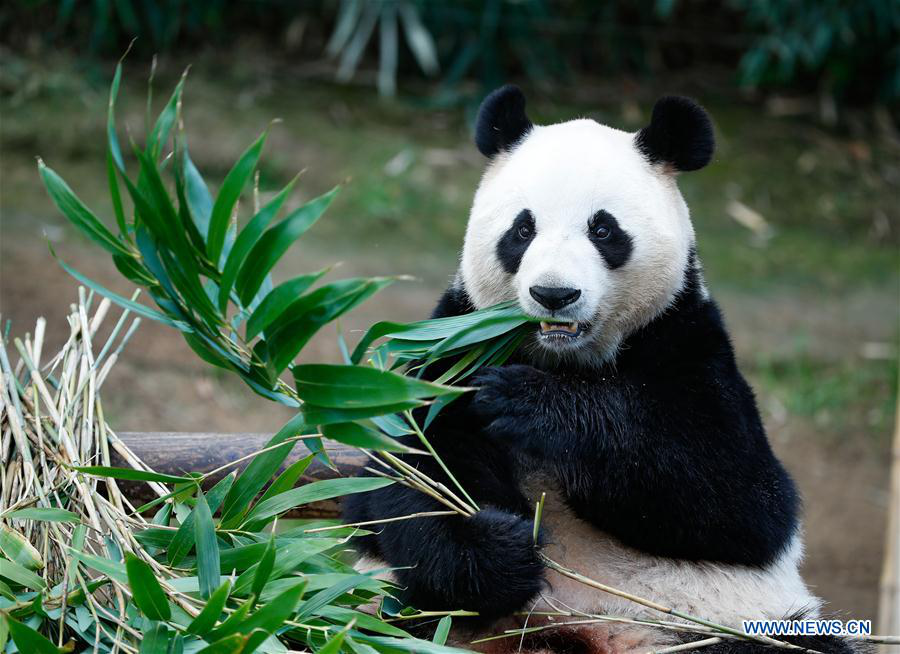

In [103]:
pred_class,pred_idx,outputs = learn.predict(img_panda)
pred_class,(outputs * 100)

(Category black, tensor([65.63, 21.29, 13.09]))

In [0]:
!wget https://silkflowersdecoflora.co.uk/image/cache/catalog/Silk%20Flowers/Daffodils/Grande-daffodil-yellow-750x750.jpg -o log

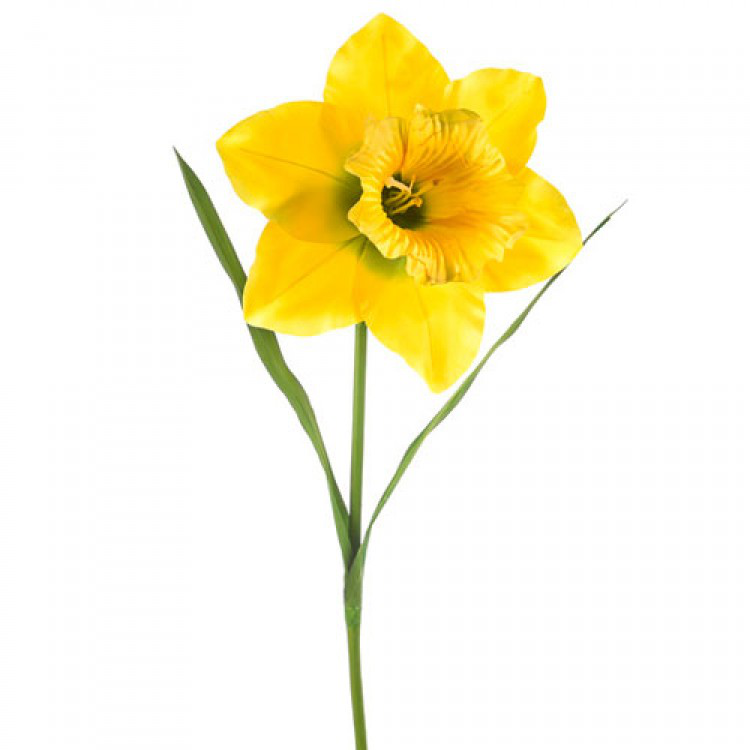

In [78]:
img_daffodil = open_image(Path()/'Grande-daffodil-yellow-750x750.jpg')
img_daffodil

In [106]:
pred_class,pred_idx,outputs = learn.predict(img_daffodil)
pred_class, outputs

(Category teddys, tensor([1.42e-03, 5.62e-04, 9.98e-01]))

In [111]:
torch.set_printoptions(precision=6, profile='short')
outputs

tensor([1.420422e-03, 5.622033e-04, 9.980173e-01])